In this notebook we implement a class that takes as constructor input a dot file as generated by torchview.draw_graph(...) and generates a py file (Python source code) that can used as input for the PlotNeuralNet Python application. 

In [1]:
from torch_snippets import *
from pathlib import PurePath
import math
import torch 
from torchsummary import summary
from pytorch_model_summary import summary as keras_summary
import torchview
from DotToPlotNeuralNet.DotToPlotNeuralNet import DotToPlotNeuralNet
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We need the conv(...) and up_conv(...) functions as they are not part of PyTorch

In [2]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [3]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In order to load a model we will need the model structure definition

In [4]:
class UNet(nn.Module):
    def __init__(self, out_channels=2):
        super().__init__()

        self.conv11 = conv(3, 64)
        self.conv12 = conv(64, 64)

        self.conv21 = conv(64, 128)
        self.conv22 = conv(128, 128)

        self.conv31 = conv(128, 256)
        self.conv32 = conv(256, 256)

        self.conv41 = conv(256, 512)
        self.conv42 = conv(512, 512)

        self.conv51 = conv(512, 1024)
        self.conv52 = conv(1024, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.conv43 = conv(512 + 512, 512)
        self.conv44 = conv(512, 512)

        self.up_conv4 = up_conv(512, 256)
        self.conv33 = conv(256 + 256, 256)
        self.conv34 = conv(256, 256)

        self.up_conv3 = up_conv(256, 128)
        self.conv23 = conv(128 + 128, 128)
        self.conv24 = conv(128, 128)

        self.up_conv2 = up_conv(128, 64)
        self.conv13 = conv(64 + 64, 64)
        self.conv14 = conv(64, 64)
        self.conv15 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.maxPool = nn.MaxPool2d(2)

        self.crop1 = torchvision.transforms.CenterCrop((392,392))
        self.crop2 = torchvision.transforms.CenterCrop((200,200))
        self.crop3 = torchvision.transforms.CenterCrop((104,104))
        self.crop4 = torchvision.transforms.CenterCrop((56,56))

        self.ReLU = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv2d,
                nn.ConvTranspose2d
            }:
                fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                std = 1 / math.sqrt(fan_out / 2)
                nn.init.normal_(m.weight.data, 0, std)
                if m.bias is not None:
                    #nn.init.uniform_(m.bias, -std, std)
                    nn.init.normal_(m.weight.data, 0, std)

    def forward(self, x):               # 572*572

        x = self.conv11(x)              # 570*570
        block1 = self.conv12(x)         # 568*568
        x = self.maxPool(block1)        # 284*284
       
        x = self.conv21(x)              # 282*282

        block2 = self.conv22(x)         # 280*280
        x = self.maxPool(block2)        # 140*140
       
        x = self.conv31(x)              # 138 * 138
        block3 = self.conv32(x)         # 136 * 136
        x = self.maxPool(block3)        # 68 * 68

        x = self.conv41(x)              # 66*66
        block4 = self.conv42(x)         # 64*64 
        x = self.maxPool(block4)        # 32*32

        x = self.conv51(x)              # 30*30
        x = self.conv52(x)              # 28*28
        x = self.up_conv5(x)            # 56*56

        block4 = self.crop4(block4)     # 56*56
        x = torch.cat([x, block4], dim=1) 
        x = self.conv43(x)              # 54*54
        x = self.conv44(x)              # 52*52
        x = self.up_conv4(x)            # 104*104

        block3 = self.crop3(block3)     # 104*104
        x = torch.cat([x, block3], dim=1) 
        x = self.conv33(x)              # 102*102
        x = self.conv34(x)              # 100*100
        x = self.up_conv3(x)            # 200*200

        block2 = self.crop2(block2)     # 200*200
        x = torch.cat([x, block2], dim=1) 
        x = self.conv23(x)              # 198*198
        x = self.conv24(x)              # 196*196
        x = self.up_conv2(x)            # 392*392
        
        block1 = self.crop1(block1)     # 392*392
        x = torch.cat([x, block1], dim=1) 
        x = self.conv13(x)              # 390*390
        x = self.conv14(x)              # 388*388
        x = self.conv15(x)              # 388*388
        x = self.ReLU(x)                # 388*388
        
        return x

We also reuse the Dataset object for easy access to training data

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [6]:
class SegData(Dataset):
    def __init__(self, aug=None):
        self.items = stems(f'isbi-datasets-master/data/deformed_images')
        self.aug = aug
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        name = PurePath(self.items[ix]).name[-5:]
        image = read(f'isbi-datasets-master/data/deformed_images/train-volume{name}.jpg',1)
        image = cv2.resize(image, (572,572))
        mask = read(f'isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png')
        mask = cv2.resize(mask, (572,572))
        with open('isbi-datasets-master/data/wx/wx' + name + '.npy', 'rb') as f:
            wx = np.load(f)
        return image, mask, wx
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks, wxs = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        wxs = torch.cat([torch.Tensor(wx[None]) for wx in wxs]).float().to(device)
        return ims, ce_masks, wxs

In [7]:
trn_ds = SegData()
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)

We use our trained UNet model

In [8]:
model = torch.load('20_epoch_weighted_CE_loss.pt',map_location=torch.device('cpu'))
im, mask, dist_transform = next(iter(trn_dl))

First, the summary

In [9]:
MODEL = UNet().to(device)
summary(MODEL, (3,572,572));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 570, 570]        --
|    └─Conv2d: 2-1                       [-1, 64, 570, 570]        1,792
|    └─ReLU: 2-2                         [-1, 64, 570, 570]        --
├─Sequential: 1-2                        [-1, 64, 568, 568]        --
|    └─Conv2d: 2-3                       [-1, 64, 568, 568]        36,928
|    └─ReLU: 2-4                         [-1, 64, 568, 568]        --
├─MaxPool2d: 1-3                         [-1, 64, 284, 284]        --
├─Sequential: 1-4                        [-1, 128, 282, 282]       --
|    └─Conv2d: 2-5                       [-1, 128, 282, 282]       73,856
|    └─ReLU: 2-6                         [-1, 128, 282, 282]       --
├─Sequential: 1-5                        [-1, 128, 280, 280]       --
|    └─Conv2d: 2-7                       [-1, 128, 280, 280]       147,584
|    └─ReLU: 2-8                         [-1, 128, 280, 280]       --

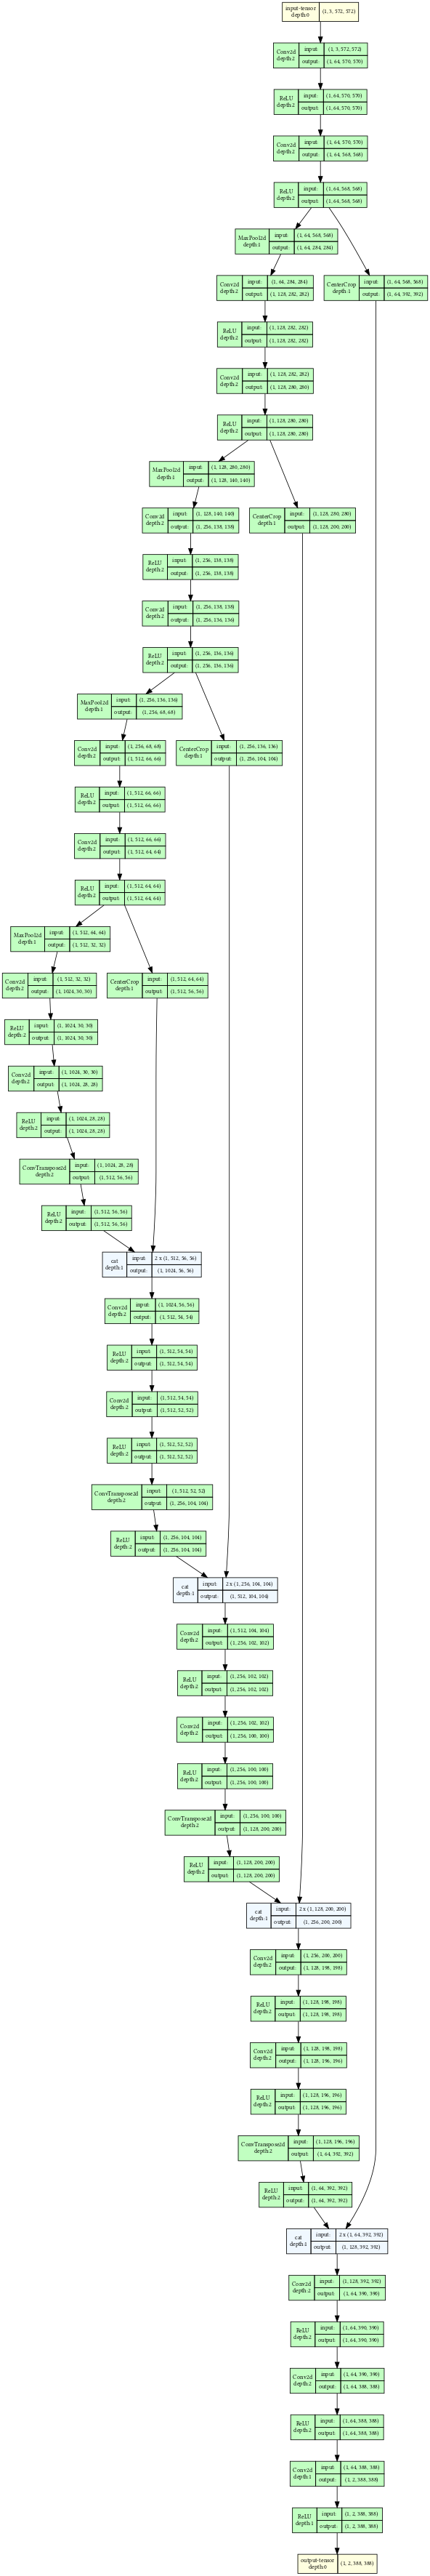

In [10]:
im, mask, dist_transform = next(iter(trn_dl))
model_graph = torchview.draw_graph(MODEL, input_size=(1, 3, 572, 572), device='meta')
model_graph.visual_graph

So, finally after some days of futile hacking we got the following graph model:

In [11]:
dot=model_graph.visual_graph.source
plotInstance = DotToPlotNeuralNet(dot)
plotInstance.create_PlotNeuralNet_content()

[
    '\n\\documentclass[border=8pt, multi, tikz]{standalone} 
\n\\usepackage{import}\n\\subimport{../layers/}{init}\n\\usetikzlibrary{positioning}\n\\usetikzlibrary{3d} %for 
including external image \n',
    '\n\\def\\ConvColor{rgb:yellow,5;red,2.5;white,5}\n\\def\\ConvReluColor{rgb:yellow,5;red,5;white,5}\n\\def\\Poo
lColor{rgb:red,1;black,0.3}\n\\def\\UnpoolColor{rgb:blue,2;green,1;black,0.3}\n\\def\\FcColor{rgb:blue,5;red,2.5;wh
ite,5}\n\\def\\FcReluColor{rgb:blue,5;red,5;white,4}\n\\def\\SoftmaxColor{rgb:magenta,5;black,7}   
\n\\def\\SumColor{rgb:blue,5;green,15}\n',
    '\n\\newcommand{\\copymidarrow}{\\tikz \\draw[-Stealth,line 
width=0.8mm,draw={rgb:blue,4;red,1;green,1;black,3}] (-0.3,0) -- 
++(0.3,0);}\n\n\\begin{document}\n\\begin{tikzpicture}\n\\tikzstyle{connection}=[ultra thick,every 
node/.style={sloped,allow upside down},draw=\\edgecolor,opacity=0.7]\n\\tikzstyle{copyconnection}=[ultra 
thick,every node/.style={sloped,allow upside down},draw={rgb:blue,4;red,1;green,1;black,3},opacity=0.7]\n',
    '\n\\pic[shift={(0,0,0)}] at (0,0,0) \n    {Box={\n        name=conv1,\n        caption= ,\n        
xlabel={{64, }},\n        zlabel=570,\n        fill=\\ConvColor,\n        height=40,\n        width=3,\n        
depth=40\n        }\n    };\n',
    '\n\\pic[shift={(0,0,0)}] at (conv1-east) \n    {Box={\n        name=conv2,\n        caption= ,\n        
xlabel={{64, }},\n        zlabel=568,\n        fill=\\ConvColor,\n        height=39,\n        width=3,\n        
depth=39\n        }\n    };\n',
    '\n\\pic[shift={ (0,0,0) }] at (conv2-east) \n    {Box={\n        name=pool1,\n        caption= ,\n        
fill=\\PoolColor,\n        opacity=0.5,\n        height=34,\n        width=2,\n        depth=34\n        }\n    
};\n',
    '\n\\pic[shift={(2,0,0)}] at (pool1-east) \n    {Box={\n        name=conv3,\n        caption= ,\n        
xlabel={{128, }},\n        zlabel=282,\n        fill=\\ConvColor,\n        height=33,\n        width=5,\n        
depth=33\n        }\n    };\n',
    '\n\\draw [connection]  (pool1-east)    -- node {\\midarrow} (conv3-west);\n',
    '\n\\pic[shift={(0,0,0)}] at (conv3-east) \n    {Box={\n        name=conv4,\n        caption= ,\n        
xlabel={{128, }},\n        zlabel=280,\n        fill=\\ConvColor,\n        height=32,\n        width=5,\n        
depth=32\n        }\n    };\n',
    '\n\\pic[shift={ (0,0,0) }] at (conv4-east) \n    {Box={\n        name=pool2,\n        caption= ,\n        
fill=\\PoolColor,\n        opacity=0.5,\n        height=26,\n        width=2,\n        depth=26\n        }\n    
};\n',
    '\n\\pic[shift={(2,0,0)}] at (pool2-east) \n    {Box={\n        name=conv5,\n        caption= ,\n        
xlabel={{256, }},\n        zlabel=138,\n        fill=\\ConvColor,\n        height=25,\n        width=7,\n        
depth=25\n        }\n    };\n',
    '\n\\draw [connection]  (pool2-east)    -- node {\\midarrow} (conv5-west);\n',
    '\n\\pic[shift={(0,0,0)}] at (conv5-east) \n    {Box={\n        name=conv6,\n        caption= ,\n        
xlabel={{256, }},\n        zlabel=136,\n        fill=\\ConvColor,\n        height=24,\n        width=7,\n        
depth=24\n        }\n    };\n',
    '\n\\pic[shift={ (0,0,0) }] at (conv6-east) \n    {Box={\n        name=pool3,\n        caption= ,\n        
fill=\\PoolColor,\n        opacity=0.5,\n        height=19,\n        width=2,\n        depth=19\n        }\n    
};\n',
    '\n\\pic[shift={(2,0,0)}] at (pool3-east) \n    {Box={\n        name=conv7,\n        caption= ,\n        
xlabel={{512, }},\n        zlabel=66,\n        fill=\\ConvColor,\n        height=17,\n        width=9,\n        
depth=17\n        }\n    };\n',
    '\n\\draw [connection]  (pool3-east)    -- node {\\midarrow} (conv7-west);\n',
    '\n\\pic[shift={(0,0,0)}] at (conv7-east) \n    {Box={\n        name=conv8,\n        caption= ,\n        
xlabel={{512, }},\n        zlabel=64,\n        fill=\\ConvColor,\n        height=16,\n        width=9,\n        
depth=16\n        }\n 

In [12]:
d.create_pdf('ddn10')


\documentclass[border=8pt, multi, tikz]{standalone} 
\usepackage{import}
\subimport{../layers/}{init}
\usetikzlibrary{positioning}
\usetikzlibrary{3d} %for including external image 


\def\ConvColor{rgb:yellow,5;red,2.5;white,5}
\def\ConvReluColor{rgb:yellow,5;red,5;white,5}
\def\PoolColor{rgb:red,1;black,0.3}
\def\UnpoolColor{rgb:blue,2;green,1;black,0.3}
\def\FcColor{rgb:blue,5;red,2.5;white,5}
\def\FcReluColor{rgb:blue,5;red,5;white,4}
\def\SoftmaxColor{rgb:magenta,5;black,7}   
\def\SumColor{rgb:blue,5;green,15}


\newcommand{\copymidarrow}{\tikz \draw[-Stealth,line width=0.8mm,draw={rgb:blue,4;red,1;green,1;black,3}] (-0.3,0) -- ++(0.3,0);}

\begin{document}
\begin{tikzpicture}
\tikzstyle{connection}=[ultra thick,every node/.style={sloped,allow upside down},draw=\edgecolor,opacity=0.7]
\tikzstyle{copyconnection}=[ultra thick,every node/.style={sloped,allow upside down},draw={rgb:blue,4;red,1;green,1;black,3},opacity=0.7]


\pic[shift={(0,0,0)}] at (0,0,0) 
    {Box={
        name

.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmodulematrix.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/frontendlayer/tikz/libraries/tik
zlibrarytopaths.code.tex))))
(/usr/share/texlive/texmf-dist/tex/latex/import/import.sty)
(../layers/../layers/init.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/frontendlayer/tikz/libraries/tik
zlibraryquotes.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/libraries/pgflibraryarrows.meta.
code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/frontendlayer/tikz/libraries/tik
zlibrarypositioning.code.tex) (../layers/../layers//Ball.sty

LaTeX Warning: You have requested package `../layers//Ball',
               but the package provides `Ball'.

) (../layers/../layers//Box.sty

LaTeX Warning: You have requested package `../layers//Box',
               but the package provides `Box'.

) (../layers/../layers//RightBandedBox.sty

LaTeX Warning: You have requested package `../layers//RightBandedBox',
     